## Testes adicionais


Este caderno tem como objetivo tentar melhorar os resultados obtidos no modelo de variáveis desagregadas para 2018 a 2024.

### Bibliotecas e base de dados

In [1]:
# Importar bibliotecas
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, recall_score
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
import xgboost as xgb
from skopt import BayesSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn import metrics

#Estilizar conteúdo
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

def estilo_tabelas(df, max_altura='300px', casas_decimais=3):
    return (
        df.style.set_table_styles(
            [
                {'selector': 'thead th', 'props': [('font-size', '12px'), ('text-align', 'center'), ('border-bottom', '2px solid #007BFF')]},
                {'selector': 'td', 'props': [('font-size', '10px'), ('text-align', 'center'), ('max-height', '40px'), ('white-space', 'nowrap'), ('text-overflow', 'ellipsis'), ('overflow', 'hidden'), ('max-width', '100px')]},
                {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]},
                {'selector': 'table', 'props': [('width', '90%'), ('margin-left', 'auto'), ('margin-right', 'auto'), ('border-collapse', 'collapse')]},
                {'selector': 'td, th', 'props': [('border', '1px solid #666')]},  # Bordas cinza escuro
            ]
        ).set_properties(
            **{'border-color': 'darkgray', 'border-style': 'solid', 'border-width': '1px'}
        ).set_table_attributes(
            f'style="height:auto; overflow:auto; max-height:{max_altura}; display:block;"'  
        ).format(
            precision=casas_decimais  
        )
    )

# Importar a base de dados

df_eventos_2018_2024_modelo2 = pd.read_csv(
    "https://raw.githubusercontent.com/brunagmoura/PrevisorReconhecimento/refs/heads/main/df_eventos_2018_2024_modelo2.csv",
    sep=';',
    decimal=',',
)

estilo_tabelas(df_eventos_2018_2024_modelo2.head(5))

,Status,DH_MORTOS,DH_FERIDOS,DH_ENFERMOS,DH_DESABRIGADOS,DH_DESALOJADOS,DH_DESAPARECIDOS,DH_OUTROS AFETADOS,DM_Uni Habita Danificadas,DM_Uni Habita Destruidas,DM_Uni Habita Valor,DM_Inst Saúde Danificadas,DM_Inst Saúde Destruidas,DM_Inst Saúde Valor,DM_Inst Ensino Danificadas,DM_Inst Ensino Destruidas,DM_Inst Ensino Valor,DM_Inst Serviços Danificadas,DM_Inst Serviços Destruidas,DM_Inst Serviços Valor,DM_Inst Comuni Danificadas,DM_Inst Comuni Destruidas,DM_Inst Comuni Valor,DM_Obras de Infra Danificadas,DM_Obras de Infra Destruidas,DM_Obras de Infra Valor,PEPL_Assis_méd e emergên(R$),PEPL_Abast de água pot(R$),PEPL_sist de esgotos sanit(R$),PEPL_Sis limp e rec lixo (R$),PEPL_Sis cont pragas (R$),PEPL_distrib energia (R$),PEPL_Telecomunicações (R$),PEPL_Tran loc/reg/l_curso (R$),PEPL_Distrib combustíveis(R$),PEPL_Segurança pública (R$),PEPL_Ensino (R$),PEPR_Agricultura (R$),PEPR_Pecuária (R$),PEPR_Indústria (R$),PEPR_Comércio (R$),PEPR_Serviços (R$),DensidadePop,DOMICILIO_AREARURAL,PDEFAGUA,PDEFESGOTO,PDEFLIXO,PDEFSAN,QTDE_FAMILIAS_ATUALIZADAS,Sigla_UF_AC,Sigla_UF_AL,Sigla_UF_AM,Sigla_UF_AP,Sigla_UF_BA,Sigla_UF_CE,Sigla_UF_DF,Sigla_UF_ES,Sigla_UF_GO,Sigla_UF_MA,Sigla_UF_MG,Sigla_UF_MS,Sigla_UF_MT,Sigla_UF_PA,Sigla_UF_PB,Sigla_UF_PE,Sigla_UF_PI,Sigla_UF_PR,Sigla_UF_RJ,Sigla_UF_RN,Sigla_UF_RO,Sigla_UF_RR,Sigla_UF_RS,Sigla_UF_SC,Sigla_UF_SE,Sigla_UF_SP,Sigla_UF_TO,Sigla_UF_pa,COBRADE_11110,COBRADE_11120,COBRADE_11311,COBRADE_11312,COBRADE_11313,COBRADE_11321,COBRADE_11331,COBRADE_11332,COBRADE_11340,COBRADE_11410,COBRADE_11420,COBRADE_11431,COBRADE_11432,COBRADE_11433,COBRADE_12100,COBRADE_12200,COBRADE_12300,COBRADE_13111,COBRADE_13112,COBRADE_13120,COBRADE_13211,COBRADE_13212,COBRADE_13213,COBRADE_13214,COBRADE_13215,COBRADE_13310,COBRADE_13321,COBRADE_13322,COBRADE_14110,COBRADE_14120,COBRADE_14131,COBRADE_14132,COBRADE_14140,COBRADE_15110,COBRADE_15120,COBRADE_15130,COBRADE_15210,COBRADE_15230,COBRADE_22210,COBRADE_22220,COBRADE_23120,COBRADE_24100,COBRADE_24200,COBRADE_25100,COBRADE_25500
0,0,0,0,0,0,0,0,11650,0,0,0.000,0.000,0,0.000,0.000,0,0.000,0,0,0.000,0,0,0.000,0.000,0.000,0.000,0.000,132466.926,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,264933.852,309089.494,58874.189,228137.484,0.000,134.493,0.305,0.191,0.559,0.167,0.091,383.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0,0,0,0,0,0,0,2548,0,0,0.000,0.000,0,0.000,0.000,0,0.000,0,0,0.000,0,0,0.000,0.000,0.000,0.000,0.000,103709.315,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5905738.840,603420.207,0.000,0.000,0.000,10.669,0.632,0.246,0.456,0.175,0.070,57.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,1,0,180,0,0,156,0,0,112,0,515149.157,0.000,0,0.000,0.000,0,0.000,0,0,0.000,1,0,161904.021,16.000,0.000,1619040.208,161904.021,0.000,0.000,1766225.681,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,nan,0.708,0.691,0.851,0.691,0.576,356.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000

### Manipulação da base de dados

In [2]:
# Inclusão de features derivadas, tratando dados ausentes como 0
df_eventos_2018_2024_modelo2['DH_FERIDOS_ENFERMOS'] = df_eventos_2018_2024_modelo2['DH_FERIDOS'].fillna(0) + df_eventos_2018_2024_modelo2['DH_ENFERMOS'].fillna(0)
df_eventos_2018_2024_modelo2['DH_DESABRIGADOS_DESALOJADOS'] = df_eventos_2018_2024_modelo2['DH_DESABRIGADOS'].fillna(0) + df_eventos_2018_2024_modelo2['DH_DESALOJADOS'].fillna(0)
df_eventos_2018_2024_modelo2['DH_DESAPARECIDOS'] = df_eventos_2018_2024_modelo2['DH_DESAPARECIDOS'].fillna(0)
df_eventos_2018_2024_modelo2['DH_MORTOS'] = df_eventos_2018_2024_modelo2['DH_MORTOS'].fillna(0)
df_eventos_2018_2024_modelo2['DM_Uni_Habita_Danificadas_Destruidas'] = df_eventos_2018_2024_modelo2['DM_Uni Habita Danificadas'].fillna(0) + df_eventos_2018_2024_modelo2['DM_Uni Habita Destruidas'].fillna(0)
df_eventos_2018_2024_modelo2['DM_Uni_Habita_Valor'] = df_eventos_2018_2024_modelo2['DM_Uni Habita Valor'].fillna(0)
df_eventos_2018_2024_modelo2['DM_Inst_Saude_Danificadas_Destruidas'] = df_eventos_2018_2024_modelo2['DM_Inst Saúde Danificadas'].fillna(0) + df_eventos_2018_2024_modelo2['DM_Inst Saúde Destruidas'].fillna(0)
df_eventos_2018_2024_modelo2['DM_Inst_Saude_Valor'] = df_eventos_2018_2024_modelo2['DM_Inst Saúde Valor'].fillna(0)
df_eventos_2018_2024_modelo2['DM_Inst_Ensino_Danificadas_Destruidas'] = df_eventos_2018_2024_modelo2['DM_Inst Ensino Danificadas'].fillna(0) + df_eventos_2018_2024_modelo2['DM_Inst Ensino Destruidas'].fillna(0)
df_eventos_2018_2024_modelo2['DM_Inst_Ensino_Valor'] = df_eventos_2018_2024_modelo2['DM_Inst Ensino Valor'].fillna(0)
df_eventos_2018_2024_modelo2['DM_Inst_Servicos_Danificadas_Destruidas'] = df_eventos_2018_2024_modelo2['DM_Inst Serviços Danificadas'].fillna(0) + df_eventos_2018_2024_modelo2['DM_Inst Serviços Destruidas'].fillna(0)
df_eventos_2018_2024_modelo2['DM_Inst_Servicos_Valor'] = df_eventos_2018_2024_modelo2['DM_Inst Serviços Valor'].fillna(0)
df_eventos_2018_2024_modelo2['DM_Inst_Comuni_Danificadas_Destruidas'] = df_eventos_2018_2024_modelo2['DM_Inst Comuni Danificadas'].fillna(0) + df_eventos_2018_2024_modelo2['DM_Inst Comuni Destruidas'].fillna(0)
df_eventos_2018_2024_modelo2['DM_Inst_Comuni_Valor'] = df_eventos_2018_2024_modelo2['DM_Inst Comuni Valor'].fillna(0)
df_eventos_2018_2024_modelo2['DM_Obras_Infra_Danificadas_Destruidas'] = df_eventos_2018_2024_modelo2['DM_Obras de Infra Danificadas'].fillna(0) + df_eventos_2018_2024_modelo2['DM_Obras de Infra Destruidas'].fillna(0)
df_eventos_2018_2024_modelo2['DM_Obras_Infra_Valor'] = df_eventos_2018_2024_modelo2['DM_Obras de Infra Valor'].fillna(0)

#Excluir colunas que sobraram após agregação
colunas_a_remover = ['DH_FERIDOS', 'DH_ENFERMOS', 'DH_DESABRIGADOS', 'DH_DESALOJADOS',
                     'DH_DESAPARECIDOS', 'DH_MORTOS', 'DM_Uni Habita Danificadas', 'DM_Uni Habita Destruidas',
                     'DM_Uni Habita Valor', 'DM_Inst Saúde Danificadas', 'DM_Inst Saúde Destruidas', 
                     'DM_Inst Saúde Valor', 'DM_Inst Ensino Danificadas', 'DM_Inst Ensino Destruidas', 
                     'DM_Inst Ensino Valor', 'DM_Inst Serviços Danificadas', 'DM_Inst Serviços Destruidas', 
                     'DM_Inst Serviços Valor', 'DM_Inst Comuni Danificadas', 'DM_Inst Comuni Destruidas', 
                     'DM_Inst Comuni Valor', 'DM_Obras de Infra Danificadas', 'DM_Obras de Infra Destruidas', 
                     'DM_Obras de Infra Valor']

df_eventos_2018_2024_modelo2 = df_eventos_2018_2024_modelo2.drop(columns=colunas_a_remover)

#Excluir linhas com dados ausentes
df_eventos_2018_2024_modelo2 = df_eventos_2018_2024_modelo2.dropna()

estilo_tabelas(df_eventos_2018_2024_modelo2.head())

,Status,DH_OUTROS AFETADOS,PEPL_Assis_méd e emergên(R$),PEPL_Abast de água pot(R$),PEPL_sist de esgotos sanit(R$),PEPL_Sis limp e rec lixo (R$),PEPL_Sis cont pragas (R$),PEPL_distrib energia (R$),PEPL_Telecomunicações (R$),PEPL_Tran loc/reg/l_curso (R$),PEPL_Distrib combustíveis(R$),PEPL_Segurança pública (R$),PEPL_Ensino (R$),PEPR_Agricultura (R$),PEPR_Pecuária (R$),PEPR_Indústria (R$),PEPR_Comércio (R$),PEPR_Serviços (R$),DensidadePop,DOMICILIO_AREARURAL,PDEFAGUA,PDEFESGOTO,PDEFLIXO,PDEFSAN,QTDE_FAMILIAS_ATUALIZADAS,Sigla_UF_AC,Sigla_UF_AL,Sigla_UF_AM,Sigla_UF_AP,Sigla_UF_BA,Sigla_UF_CE,Sigla_UF_DF,Sigla_UF_ES,Sigla_UF_GO,Sigla_UF_MA,Sigla_UF_MG,Sigla_UF_MS,Sigla_UF_MT,Sigla_UF_PA,Sigla_UF_PB,Sigla_UF_PE,Sigla_UF_PI,Sigla_UF_PR,Sigla_UF_RJ,Sigla_UF_RN,Sigla_UF_RO,Sigla_UF_RR,Sigla_UF_RS,Sigla_UF_SC,Sigla_UF_SE,Sigla_UF_SP,Sigla_UF_TO,Sigla_UF_pa,COBRADE_11110,COBRADE_11120,COBRADE_11311,COBRADE_11312,COBRADE_11313,COBRADE_11321,COBRADE_11331,COBRADE_11332,COBRADE_11340,COBRADE_11410,COBRADE_11420,COBRADE_11431,COBRADE_11432,COBRADE_11433,COBRADE_12100,COBRADE_12200,COBRADE_12300,COBRADE_13111,COBRADE_13112,COBRADE_13120,COBRADE_13211,COBRADE_13212,COBRADE_13213,COBRADE_13214,COBRADE_13215,COBRADE_13310,COBRADE_13321,COBRADE_13322,COBRADE_14110,COBRADE_14120,COBRADE_14131,COBRADE_14132,COBRADE_14140,COBRADE_15110,COBRADE_15120,COBRADE_15130,COBRADE_15210,COBRADE_15230,COBRADE_22210,COBRADE_22220,COBRADE_23120,COBRADE_24100,COBRADE_24200,COBRADE_25100,COBRADE_25500,DH_FERIDOS_ENFERMOS,DH_DESABRIGADOS_DESALOJADOS,DM_Uni_Habita_Danificadas_Destruidas,DM_Uni_Habita_Valor,DM_Inst_Saude_Danificadas_Destruidas,DM_Inst_Saude_Valor,DM_Inst_Ensino_Danificadas_Destruidas,DM_Inst_Ensino_Valor,DM_Inst_Servicos_Danificadas_Destruidas,DM_Inst_Servicos_Valor,DM_Inst_Comuni_Danificadas_Destruidas,DM_Inst_Comuni_Valor,DM_Obras_Infra_Danificadas_Destruidas,DM_Obras_Infra_Valor
0,0,11650,0.000,132466.926,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,264933.852,309089.494,58874.189,228137.484,0.000,134.493,0.305,0.191,0.559,0.167,0.091,383.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0,0,0.000,0.000,0.000,0.000,0.000,0,0.000,0,0.000,0.000,0.000
1,0,2548,0.000,103709.315,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5905738.840,603420.207,0.000,0.000,0.000,10.669,0.632,0.246,0.456,0.175,0.070,57.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0,0,0.000,0.000,0.000,0.000,0.000,0,0.000,0,0.000,0.000,0.000
2,1,0,161904.021,0.000,0.000,1766225.681,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,nan,0.708,0.691,0.851,0.691,0.576,356.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,180,156,112,515149.157,0.000,0.000,0.000,0.000,0,0.000,1,161904.021,16.000,1619040.208
3,0,360,0.000,0.000,1124880.000,0.000,0.000,0.000,0.000,7850000.000,0.000,0.000,0.0

In [4]:
# Balanceamento da variável target

status_counts = df_eventos_2018_2024_modelo2['Status'].value_counts()
print("\nBalanceamento da variável 'Status':")
display(status_counts)


Balanceamento da variável 'Status':


Status
0    7549
1     726
Name: count, dtype: int64

### Modelo sem balanceamento e com scale_pos_weight

#### Treino e Teste

In [5]:
X_2018_2024_modelo2 = df_eventos_2018_2024_modelo2.drop('Status', axis=1)

y_2018_2024_modelo2 = df_eventos_2018_2024_modelo2['Status']

X_train_2018_2024_modelo2, X_test_2018_2024_modelo2, y_train_2018_2024_modelo2, y_test_2018_2024_modelo2 = train_test_split(X_2018_2024_modelo2, y_2018_2024_modelo2, test_size=0.2, random_state=1, stratify=y_2018_2024_modelo2)

#### Treinamento do modelo

In [15]:
# Definir hiperparâmetros para a busca bayesiana
param_grid_bayes = {
    'xgb__eta': [0.01, 0.015, 0.025, 0.05, 0.1],
    'xgb__gamma': [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    'xgb__max_depth': [3, 5, 7, 9, 12, 15, 17, 25],
    'xgb__min_child_weight': [1, 3, 5, 7],
    'xgb__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'xgb__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'xgb__lambda': [0.01, 0.1, 1.0],
    'xgb__alpha': [0, 0.1, 0.5, 1.0]
}

# Usar recall como métrica de scoring
scorer = make_scorer(recall_score)

# Definir scale_pos_weight
scale_pos_weight = np.sqrt(7549 / 726)

# Criar pipeline com RobustScaler e XGBoost Classifier
pipeline_xgb = Pipeline([
    ('scaler', RobustScaler()),  
    ('xgb', xgb.XGBClassifier(
        random_state=1,
        eval_metric='logloss',  
        scale_pos_weight=scale_pos_weight 
    ))
])

# Realizar a busca bayesiana com validação cruzada
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

bayes_search_xgb = BayesSearchCV(
    pipeline_xgb,
    search_spaces=param_grid_bayes,
    n_iter=30,
    cv=cv,
    scoring=scorer,
    n_jobs=-1,
    random_state=1
)

# Ajustar o modelo ao conjunto de treino balanceado
bayes_search_xgb.fit(X_train_2018_2024_modelo2, y_train_2018_2024_modelo2)

# Melhor modelo encontrado
best_xgb_model = bayes_search_xgb.best_estimator_

# Exibir os melhores hiperparâmetros
print(f"Melhores hiperparâmetros com scale_pos_weight: {bayes_search_xgb.best_params_}")

# Fazer previsões com o conjunto de teste original
y_pred_xgb_smote = best_xgb_model.predict(X_test_2018_2024_modelo2)

# Relatório de classificação
classification_report_xgb = metrics.classification_report(
    y_test_2018_2024_modelo2, y_pred_xgb_smote, digits=6, target_names=['Reconhecido', 'Não reconhecido']
)

print('Classification report para XGBoost com scale_pos_weight: \n')
print(classification_report_xgb)


Melhores hiperparâmetros com scale_pos_weight: OrderedDict([('xgb__alpha', 0.5), ('xgb__colsample_bytree', 1.0), ('xgb__eta', 0.1), ('xgb__gamma', 0.05), ('xgb__lambda', 0.01), ('xgb__max_depth', 3), ('xgb__min_child_weight', 3), ('xgb__subsample', 1.0)])
Classification report para XGBoost com scale_pos_weight: 

                 precision    recall  f1-score   support

    Reconhecido   0.952135  0.974834  0.963351      1510
Não reconhecido   0.651376  0.489655  0.559055       145

       accuracy                       0.932326      1655
      macro avg   0.801755  0.732245  0.761203      1655
   weighted avg   0.925784  0.932326  0.927929      1655



#### Teste de overfitting e Matriz de confusão

In [11]:
# Acurácia no conjunto de treino
y_train_pred_smote = best_xgb_model.predict(X_train_2018_2024_modelo2)
acuracia_treino = metrics.accuracy_score(y_train_2018_2024_modelo2, y_train_pred_smote)

# Acurácia no conjunto de teste
acuracia_teste = metrics.accuracy_score(y_test_2018_2024_modelo2, y_pred_xgb_smote)

print(f"Acurácia no conjunto de treino: {acuracia_treino:.6f}")
print(f"Acurácia no conjunto de teste: {acuracia_teste:.6f}")

Acurácia no conjunto de treino: 0.935196
Acurácia no conjunto de teste: 0.932326


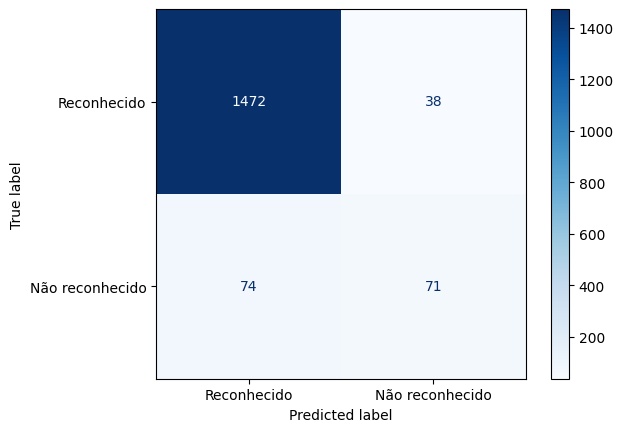

In [14]:
ConfusionMatrixDisplay.from_estimator(bayes_search_xgb, X_test_2018_2024_modelo2, y_test_2018_2024_modelo2, 
                                      values_format='d', cmap='Blues', display_labels=['Reconhecido', 'Não reconhecido'])